# In Depth: Principal Component Analysis

PCA is fundamentally a dimensionality reduction algorithm, but it can also be useful as 
- a tool for visualization,
- for noise filtering,
- for feature extraction and engineering,
- and much more

Let's start with the theory.

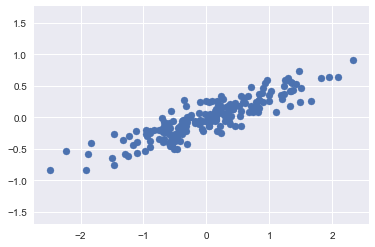

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

## Introducing Principal Component Analysis

The unsupervised learning problem attempts to learn about the relationship between the x and y values.

In principal component analysis, this relationship is quantified by finding a list of the principal axes in the data, and using those axes to describe the dataset.

In [9]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [10]:
print(pca.components_)
print(pca.explained_variance_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


- the "components" are the orientation of the _principal axes_ (i.e. a unit vector)
- the "explained variance" is the variance of the data projected on the axes (i.e. the norm of the vector)

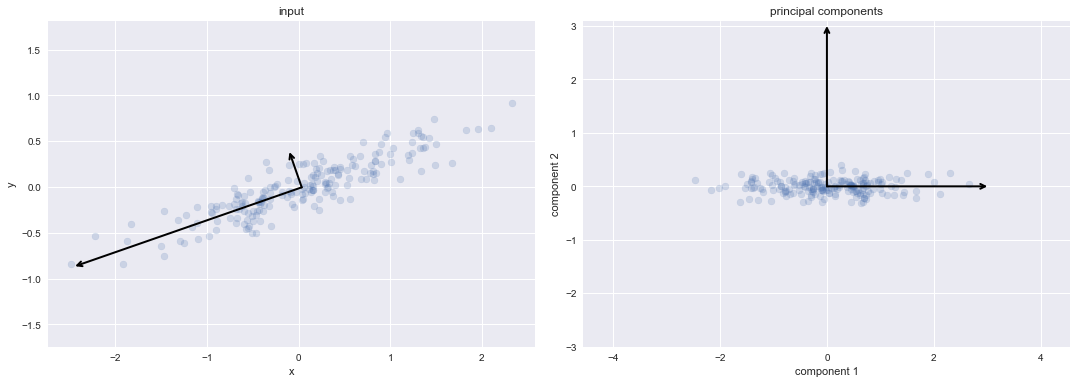

In [12]:
def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
# plot data

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
_ = ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))


# PCA as dimensionality reduction

Using PCA for dimensionality reduction involves zeroing out one or more of the smallest principal components, resulting in a lower-dimensional projection of the data that preserves the maximal data variance.

In [13]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


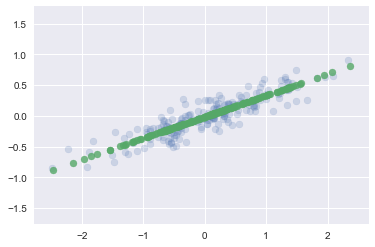

In [14]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8)
plt.axis('equal');

We can see the effect of dimension reduction. Despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

## PCA for visualization: Hand-written digits

See [PDSN] Decision Trees and Random Forests.

In [15]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [16]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


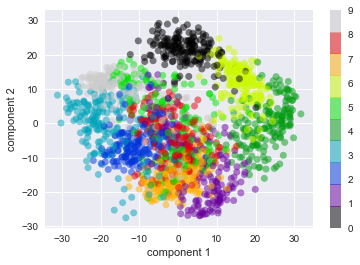

In [18]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

 Essentially, we have found the optimal stretch and rotation in 64-dimensional space that allows us to see the layout of the digits in two dimensions, and have done this in an unsupervised manner—that is, without reference to the labels.

### What do components mean ?

We can go a bit further here, and begin to ask what the reduced dimensions mean. This meaning can be understood in terms of combinations of basis vectors. For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector x:
$$
x = [x_1, x_2, ..., x_{64}]
$$

The image is currently constructed this way:

$$
image(x) = x_1.(pixel~1) + x_2.(pixel~2) + ... + x_{64}.(pixel~64)
$$

One way we might imagine reducing the dimension of this data is to zero out all but a few of these basis vectors. For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data.

![](figures/05.09-digits-pixel-components.png)

But the pixel-wise representation is not the only choice of basis. We can also use other basis functions, which each contain some pre-defined contribution from each pixel, and write something like

$$
image(x) = mean + x_1.(basis~1) + x_2.(basis~2)...
$$
PCA can be thought of as a process of choosing optimal basis functions. The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series. This figure shows a similar depiction of reconstructing this digit using the mean plus the first eight PCA basis functions:

![](figures/05.09-digits-pca-components.png)

 This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

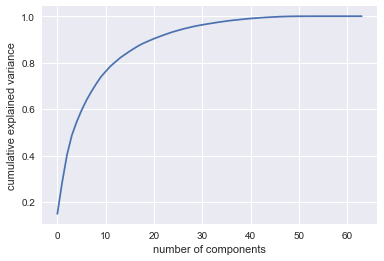

In [19]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies how much of the total, 64-dimensional variance is contained within the first N components.
==>  Looking at this plot for a high-dimensional dataset can help you __understand the level of redundancy present in multiple observations__.

## PCA as noise filtering

he idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise. So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.

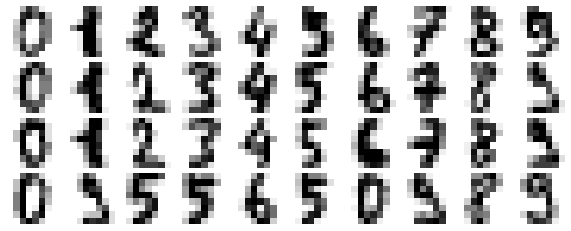

In [20]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(10, 4),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

Now lets add some random noise to create a noisy dataset, and re-plot it:

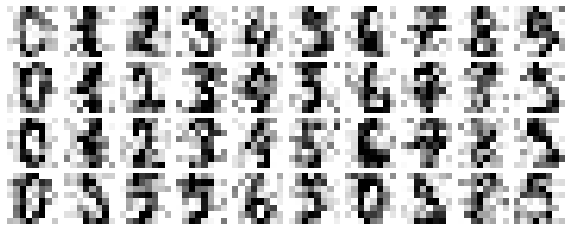

In [21]:
np.random.seed(42)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

Let's train a PCA on the noisy data, requesting that the projection preserve 50% of the variance:

pca = PCA(0.50).fit(noisy)
pca.n_components_

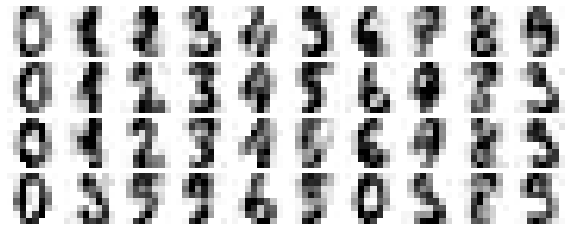

In [23]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components)
plot_digits(filtered)

Rather than training a classifier on very high-dimensional data, you might instead train the classifier on the lower-dimensional representation, which will automatically serve to filter out random noise in the inputs.

### Example 1 : 
See [PDSN] Support Vector Machines

### Example 2 : Eigenfaces


In [27]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  fa

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  img = imread(file_path)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:193: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  face = imresize(face, resize)
C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\datasets\lfw.py:184: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


This is a large dataset, we will use RandomizedPCA—it contains a randomized method to approximate the first N principal components much more quickly than the standard PCA estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000).

In [28]:
from sklearn.decomposition import RandomizedPCA
pca = RandomizedPCA(150)
pca.fit(faces.data)

C:\Users\Silvestre\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


RandomizedPCA(copy=True, iterated_power=2, n_components=150,
       random_state=None, whiten=False)

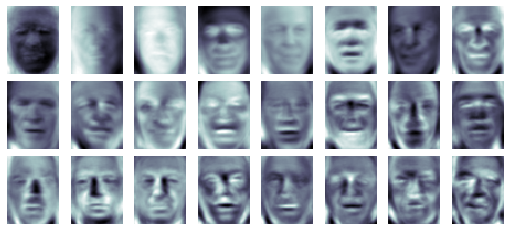

In [29]:
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

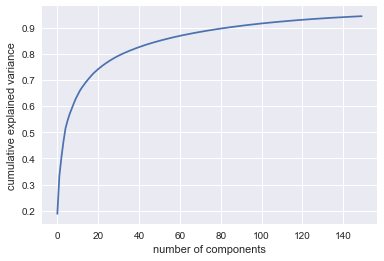

In [30]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [31]:
# Compute the components and projected faces
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

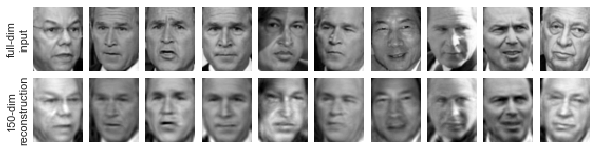

In [32]:
# Plot the results
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

# Principal Component Analysis Summary

The use of principal component analysis for :
- dimensionality reduction,
- visualization of high-dimensional data,
- noise filtering,
- feature selection within high-dimensional data. 

Given any high-dimensional dataset, I tend to start with PCA in order to visualize the relationship between points (as we did with the digits), to understand the main variance in the data (as we did with the eigenfaces), and to understand the intrinsic dimensionality (by plotting the explained variance ratio). 

PCA's main weakness is that it tends to be __highly affected by outliers__ in the data. For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components. Scikit-Learn contains a couple interesting variants on PCA, including __RandomizedPCA__ and __SparsePCA__, both also in the __sklearn.decomposition__ submodule. RandomizedPCA, which we saw earlier, uses a non-deterministic method to quickly approximate the first few principal components in very high-dimensional data, while SparsePCA introduces a regularization term (see In Depth: Linear Regression) that serves to enforce sparsity of the components.